In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
from itertools import chain
import json
import seaborn as sns
from scipy.stats import linregress
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel


def get_salience_df(name="results/salience_results_all_models.json", models=None, ds_names=None):
    salience_df = pd.read_json(name, orient="records", lines=True)
    if models:
        salience_df = salience_df[salience_df["model_name"].isin(models)]
    if ds_names:
        salience_df = salience_df[salience_df["ds_name"].isin(ds_names)]
    avgd_salience_df = salience_df.groupby(["ds_name", "against", "model_name"], as_index=False).mean(numeric_only=True)
    # pivot on "against"
    salience_df = avgd_salience_df.pivot(index=["ds_name", "model_name"], columns="against")
    # flatten the index
    salience_df.columns = ['_'.join(col).strip() for col in salience_df.columns.values]
    salience_df["weak_label_acc"] = salience_df["weak_label_acc_oracle"]
    salience_df["weak_label_auroc"] = salience_df["weak_label_auroc_oracle"]
    salience_df = salience_df.drop(columns=["weak_label_acc_oracle", "weak_label_auroc_oracle", "weak_label_acc_weak", "weak_label_auroc_weak"])
    return salience_df


def load_result(path):
    path = Path(path)
    try:
        with open(path / "results.json") as f:
            data = json.load(f)
        with open(path / "config.json") as f:
            config = json.load(f)
    except FileNotFoundError:
        return
    
    stages_cfg = config["reporter"]["stages"]
    weak_compute = sum(stage["num_weak_nonunique"] * stage["train_args"]["num_train_epochs"] for stage in stages_cfg)
    oracle_compute = sum(stage["num_oracle_nonunique"] * stage["train_args"]["num_train_epochs"] for stage in stages_cfg)
    total_compute = weak_compute + oracle_compute

    # oracle_cost = int(path.name.split("_")[0].split("=")[1]
    seed = int(path.name.split("_")[-1].split("s")[-1])
    if "m=" in path.name:
        sweep_name = "_".join(path.name.split("_")[3:-1])
    else:
        sweep_name = "_".join(path.name.split("_")[2:-1])
    return {
        "auroc": data["auroc"],
        "model_name": config["model"]["name"],
        "num_oracle": data["num_oracle"],
        "num_weak": data["num_weak"],
        "num_oracle_nonunique": data["num_oracle_nonunique"],
        "num_weak_nonunique": data["num_weak_nonunique"],
        "weak_compute": weak_compute,
        "oracle_compute": oracle_compute,
        "total_compute": total_compute,
        "seed": seed,
        "ds_name": path.parent.name,
        "sweep_name": sweep_name,
    }


def get_results_df(ds_names=None, patterns=None):
    patterns = patterns or ["nw=*_seq_sft_both_estop_s*",]
    results = []
    if ds_names is None:
        ds_names = [d.name for d in Path("results").iterdir() if d.is_dir()]
    for ds_name in ds_names:
        for subdir in chain(*[Path(f"results/{ds_name}").glob(pattern) for pattern in patterns]):
            if result := load_result(subdir):
                results.append(result)
    results_df = pd.DataFrame(results)
    results_df.set_index(["ds_name", "model_name", "sweep_name"], inplace=True, drop=False)
    return results_df

reparam = "log({x} + 1)"
def reparametrize(x):
    if reparam == "log({x} + 1)":
        return np.log10(x + 1)
    elif reparam == "{x}":
        return x


# Get weak label accuracies

In [8]:
from datasets import load_from_disk

base_ds_names = ds_names = [
    "boolq",
    "anli-r2",
    "ethics-virtue",
    "ethics-utilitarianism",
    "ethics-justice",
    "ethics-deontology",
    "hellaswag",
    "amazon_polarity",
    "paws",
    "sciq_with_support",
    "sciq",
]
weak_names = [f"{name}_{wm}" for name in base_ds_names for wm in ["Qwen1.5-0.5B", "Qwen1.5-4B"]]
# weak_names = [f"{name}_{wm}" for name in ["anli-r2", "hellaswag", "ethics-deontology"] for wm in ["Qwen1.5-0.5B", "Qwen1.5-4B", "Qwen1.5-7B"]]
# weak_names = [f"{name}_{wm}" for name in ["boolq", "amazon_polarity", "sciq"] for wm in ["Qwen1.5-0.5B", "Qwen1.5-4B", "Qwen1.5-7B"]]
# weak_names += [f"{wn}_shuffled_err" for wn in weak_names]

for weak_name in weak_names:
    ds = load_from_disk(f"results/{weak_name}/weak_train")
    acc = sum((ex["soft_pred"][1] > 0.5) == ex["hard_label"] for ex in ds) / len(ds)
    print(f"{weak_name}: {acc} (n={len(ds)})")

boolq_Qwen1.5-0.5B: 0.6832254432873628 (n=7106)
boolq_Qwen1.5-4B: 0.8125527723050943 (n=7106)
anli-r2_Qwen1.5-0.5B: 0.8604305094130675 (n=28896)
anli-r2_Qwen1.5-4B: 0.9178086932447398 (n=28896)
ethics-virtue_Qwen1.5-0.5B: 0.7714285714285715 (n=4830)
ethics-virtue_Qwen1.5-4B: 0.939544513457557 (n=4830)
ethics-utilitarianism_Qwen1.5-0.5B: 0.5291722197541833 (n=13506)
ethics-utilitarianism_Qwen1.5-4B: 0.9310676736265363 (n=13506)
ethics-justice_Qwen1.5-0.5B: 0.8376669009135629 (n=19922)
ethics-justice_Qwen1.5-4B: 0.8929324365023592 (n=19922)
ethics-deontology_Qwen1.5-0.5B: 0.8810604251253881 (n=16748)
ethics-deontology_Qwen1.5-4B: 0.9230355863386673 (n=16748)
hellaswag_Qwen1.5-0.5B: 0.6754429998494051 (n=39842)
hellaswag_Qwen1.5-4B: 0.8802770945233673 (n=39842)
amazon_polarity_Qwen1.5-0.5B: 0.9648034188034188 (n=58500)
amazon_polarity_Qwen1.5-4B: 0.9730940170940171 (n=58500)
paws_Qwen1.5-0.5B: 0.927962801777452 (n=43658)
paws_Qwen1.5-4B: 0.9430115900865821 (n=43658)
sciq_with_support_Qwen

# Cost sweep

In [100]:
import pandas as pd

models = None
weak_models = [
    "Qwen/Qwen1.5-0.5B",
    "Qwen/Qwen1.5-4B",
    "Qwen/Qwen1.5-7B",
]
base_names = [
    "boolq",
    "anli-r2",
    "ethics-virtue",
    "ethics-utilitarianism",
    "ethics-justice",
    "ethics-deontology",
    "hellaswag",
    "amazon_polarity",
    "paws",
    "sciq_with_support",
]
ds_names = [
    f"{ds_name}_{model_name.split('/')[-1]}"
    for ds_name in base_names
    for model_name in weak_models
]
ds_names += [f"{weak_ds}_shuffled_err" for weak_ds in ds_names]
ds_names += [
    f"{ds_name}_{prompt}"
    for ds_name in [
        "ethics_deontology_excuse_only",
        "amazon_polarity_title_only",
        "sciq_support_contains",
        "paws_consistency",
    ]
    for prompt in [
        "weak_amplified",
        "both_amplified",
        "neither_amplified",
        "gt_amplified",
    ]
]

results_df = get_results_df(ds_names=ds_names, patterns=["nw=*_seq_sft_both_estop_s*"])
salience_df = get_salience_df("results/salienceV2.json", models=models, ds_names=ds_names)
df = results_df.join(salience_df, how="left")
df["logp1_num_weak"] = np.log10(df["num_weak"] + 1)
df["logp1_num_oracle"] = np.log10(df["num_oracle"] + 1)
df

,,auroc,model_name,num_oracle,num_weak,num_oracle_nonunique,num_weak_nonunique,weak_compute,oracle_compute,total_compute,seed,...,salience_oracle,salience_weak,seed_oracle,seed_weak,smallest_good_num_points_oracle,smallest_good_num_points_weak,weak_label_acc,weak_label_auroc,logp1_num_weak,logp1_num_oracle
ds_name,model_name,,,,,,,,,,,,,,,,,,,,,
ethics-deontology_Qwen1.5-0.5B,meta-llama/Meta-Llama-3-8B,0.758128,meta-llama/Meta-Llama-3-8B,297,0,300,0,0.0,20000.000000,20000.000000,5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,2.474216
ethics-utilitarianism_Qwen1.5-4B_shuffled_err,meta-llama/Meta-Llama-3-8B,0.836600,meta-llama/Meta-Llama-3-8B,296,4900,300,6800,19155.0,847.816667,20002.816667,5,...,25.328497,21.228996,0.0,0.0,2240.0,1280.0,0.931068,0.974858,3.690285,2.472756
ethics-justice_Qwen1.5-0.5B_shuffled_err,Qwen/Qwen1.5-4B,0.878505,Qwen/Qwen1.5-4B,5060,20,7000,20,57.0,19948.698000,20005.698000,5,...,26.645898,20.676937,0.0,0.0,1600.0,2240.0,0.837667,0.916402,1.322219,3.704236
hellaswag_Qwen1.5-0.5B_shuffled_err,Qwen/Qwen1.5-4B,0.665648,Qwen/Qwen1.5-4B,98,100,100,100,10000.0,10000.000000,20000.000000,5,...,23.084027,19.534180,0.0,0.0,1920.0,320.0,0.675468,0.737541,2.004321,1.995635
paws_Qwen1.5-0.5B_shuffled_err,meta-llama/Meta-Llama-3-8B,0.577821,meta-llama/Meta-Llama-3-8B,0,100,0,100,20000.0,0.000000,20000.000000,5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.004321,0.000000
ethics_deontology_excuse_only_both_amplified,Qwen/Qwen1.5-0.5B,0.565833,Qwen/Qwen1.5-0.5B,10,947,10,1000,19802.0,198.000000,20000.000000,5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.976808,1.041393


In [101]:
for row in salience_df.index:
    print(row)

('amazon_polarity_Qwen1.5-0.5B', 'Qwen/Qwen1.5-4B')
('amazon_polarity_Qwen1.5-0.5B', 'Qwen/Qwen1.5-7B')
('amazon_polarity_Qwen1.5-0.5B', 'meta-llama/Meta-Llama-3-8B')
('amazon_polarity_Qwen1.5-4B', 'Qwen/Qwen1.5-7B')
('amazon_polarity_Qwen1.5-4B', 'meta-llama/Meta-Llama-3-8B')
('amazon_polarity_Qwen1.5-7B', 'meta-llama/Meta-Llama-3-8B')
('anli-r2_Qwen1.5-0.5B', 'Qwen/Qwen1.5-4B')
('anli-r2_Qwen1.5-0.5B', 'Qwen/Qwen1.5-7B')
('anli-r2_Qwen1.5-0.5B', 'meta-llama/Meta-Llama-3-8B')
('anli-r2_Qwen1.5-0.5B_shuffled_err', 'Qwen/Qwen1.5-4B')
('anli-r2_Qwen1.5-0.5B_shuffled_err', 'Qwen/Qwen1.5-7B')
('anli-r2_Qwen1.5-0.5B_shuffled_err', 'meta-llama/Meta-Llama-3-8B')
('anli-r2_Qwen1.5-4B', 'Qwen/Qwen1.5-7B')
('anli-r2_Qwen1.5-4B', 'meta-llama/Meta-Llama-3-8B')
('anli-r2_Qwen1.5-4B_shuffled_err', 'Qwen/Qwen1.5-7B')
('anli-r2_Qwen1.5-4B_shuffled_err', 'meta-llama/Meta-Llama-3-8B')
('anli-r2_Qwen1.5-7B', 'meta-llama/Meta-Llama-3-8B')
('anli-r2_Qwen1.5-7B_shuffled_err', 'meta-llama/Meta-Llama-3-8B')
(

In [40]:
# Oracle usefulness: smoothly interpolate data. Sample some budget, spending frac pairs. Average over budgets. Compute argmax auc over spending fractions.
# “Optimal spending ratio” aggregated in a weird way

# Independent variables (practical parameters we care about): Weak affordable, oracle affordable, weak quality, distractor salience, desired salience

# For each, try a few different methods and spending ratios. Report a phase diagram with the best method for each, and how good it is. 

# Low-D: cost ratio vs whatever other variable I find to be most important 



## Pick an individual dataset

paws_consistency_weak_amplified


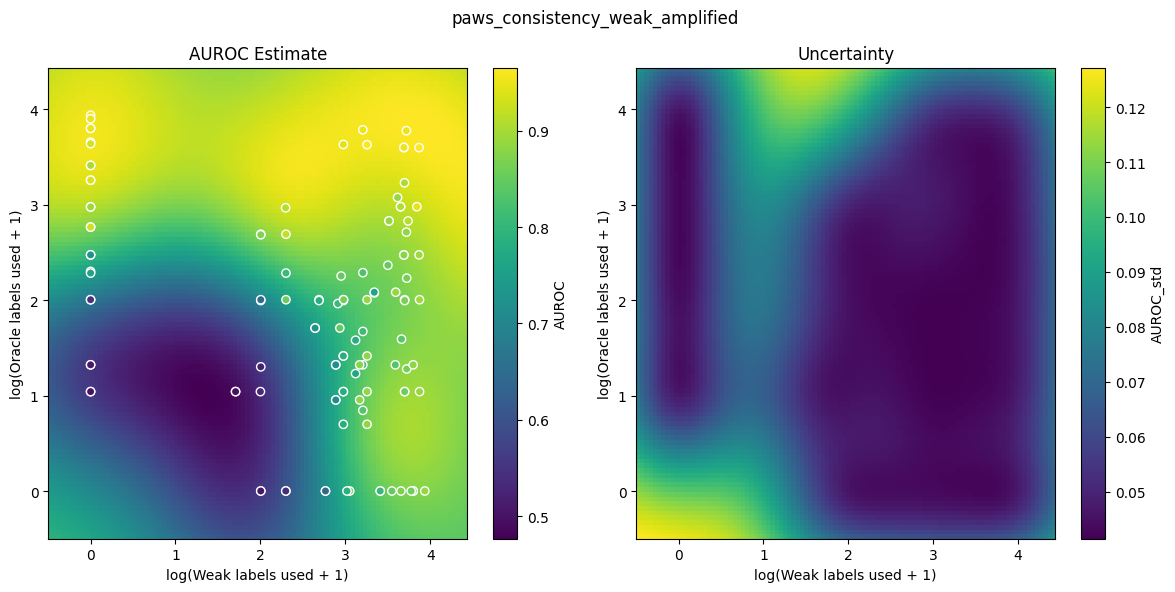

In [50]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel

ds_name = "paws_consistency_weak_amplified"
# ds_name = np.random.choice(df["ds_name"].unique())
print(ds_name)
# sweep_name = np.random.choice(["seq_sft", "salience_cfg0"])
# plot_df = df[(df["ds_name"] == ds_name) & (df["sweep_name"] == sweep_name)]
plot_df = df[df["ds_name"] == ds_name]

X = reparametrize(np.stack([plot_df["num_weak"].values, plot_df["num_oracle"].values], axis=1))  # type: ignore
y = plot_df["auroc"]

# Annoyingly, the optimizer also changes the length scale unless I fix it
kernel = 1. * RBF(length_scale=1.0, length_scale_bounds="fixed") + WhiteKernel(noise_level=0.1)
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=2, normalize_y=True)


# Fit the model
gp.fit(X, y)

# Create a grid for prediction
x_range = np.linspace(X[:, 0].min() - 0.5, X[:, 0].max() + 0.5, 100)
y_range = np.linspace(X[:, 1].min() - 0.5, X[:, 1].max() + 0.5, 100)
xx, yy = np.meshgrid(x_range, y_range)
Xgrid = np.vstack([xx.ravel(), yy.ravel()]).T

# Predict on the grid
Z, Z_std = gp.predict(Xgrid, return_std=True)  # type: ignore
Z, Z_std = Z.reshape(xx.shape), Z_std.reshape(xx.shape)

# Plot
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
ax = axs[0]
im = ax.imshow(Z, extent=[x_range.min(), x_range.max(), y_range.min(), y_range.max()],
               origin='lower', aspect='auto', cmap='viridis')
ax.scatter(X[:, 0], X[:, 1], c=y, cmap='viridis', edgecolors='w')
plt.colorbar(im, label='AUROC')
ax.set_xlabel(reparam.format(x="Weak labels used"))
ax.set_ylabel(reparam.format(x="Oracle labels used"))
ax.set_title("AUROC Estimate")
ax = axs[1]
im = ax.imshow(Z_std, extent=[x_range.min(), x_range.max(), y_range.min(), y_range.max()],
               origin='lower', aspect='auto', cmap='viridis')
plt.colorbar(im, label='AUROC_std')
ax.set_xlabel(reparam.format(x="Weak labels used"))
ax.set_ylabel(reparam.format(x="Oracle labels used"))
ax.set_title("Uncertainty")
plt.suptitle(f"{ds_name}")
plt.tight_layout()
plt.show()

In [51]:
oracle_affordable = 5000  # if you spent your whole budget on oracle, how many oracle labels could you afford?
weak_affordable = 3000
cost_ratio = weak_affordable / oracle_affordable
n_wo = np.stack([np.linspace(0, weak_affordable, 101), np.linspace(oracle_affordable, 0, 101)], axis=1)
auroc, auroc_cov = gp.predict(reparametrize(n_wo), return_std=False, return_cov=True)  # type: ignore

interp_df = pd.DataFrame({
    "num_weak": n_wo[:, 0],
    "num_oracle": n_wo[:, 1],
    "auroc": auroc,
})
interp_df["oracle_spending_frac"] = cost_ratio * interp_df["num_oracle"] / (cost_ratio * interp_df["num_oracle"] + interp_df["num_weak"])

# we want the expected optimal oracle spending fraction
# we compute the expectation over the gaussian process model
# by sampling a bunch of auroc trajectories and computing the argmax
n_boot = 1000
auroc_samples = gp.sample_y(reparametrize(n_wo), n_samples=n_boot).T
argmaxes = np.argmax(auroc_samples, axis=1)
optimal_spending_frac = interp_df["oracle_spending_frac"].values[argmaxes]
interp_df["expected_optimal_spending_frac"] = optimal_spending_frac.mean()
interp_df["optimal_spending_frac_lo"] = np.percentile(optimal_spending_frac, 2.5)
interp_df["optimal_spending_frac_hi"] = np.percentile(optimal_spending_frac, 97.5)

interp_df

,num_weak,num_oracle,auroc,oracle_spending_frac,expected_optimal_spending_frac,optimal_spending_frac_lo,optimal_spending_frac_hi
0,0.0,5000.0,0.956514,1.00,0.72718,0.25975,1.0
1,30.0,4950.0,0.921198,0.99,0.72718,0.25975,1.0
2,60.0,4900.0,0.930987,0.98,0.72718,0.25975,1.0
3,90.0,4850.0,0.938449,0.97,0.72718,0.25975,1.0
4,120.0,4800.0,0.943718,0.96,0.72718,0.25975,1.0
...,...,...,...,...,...,...,...
96,2880.0,200.0,0.863799,0.04,0.72718,0.25975,1.0
97,2910.0,150.0,0.858278,0.03,0.72718,0.25975,1.0
98,2940.0,100.0,0.853467,0.02,0.72718,0.25975,1.0
99,2970.0,50.0,0.853626,0.01,0.72718,0.25975,1.0


Text(0.5, 1.0, 'paws_consistency_weak_amplified\n3000 weak affordable, 5000 oracle affordable')

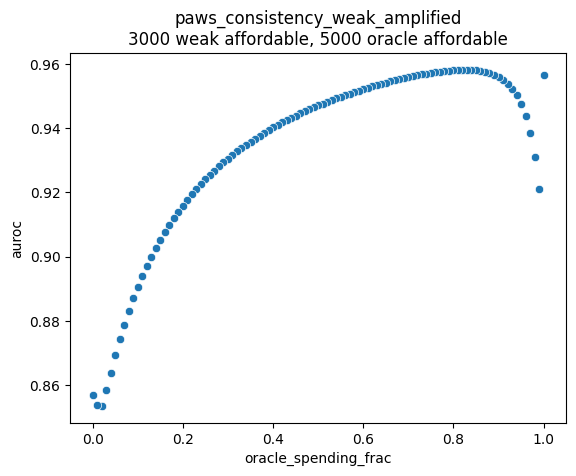

In [52]:
import seaborn as sns

sns.scatterplot(x="oracle_spending_frac", y="auroc", data=interp_df)
plt.title(f"{ds_name}\n{weak_affordable} weak affordable, {oracle_affordable} oracle affordable")

In [53]:
from scipy.stats import linregress
optimal_oracle_spending_frac = interp_df["oracle_spending_frac"].iloc[interp_df["auroc"].argmax()]
r = linregress(interp_df["oracle_spending_frac"], interp_df["auroc"]).rvalue
r

0.8210030177902164

# Check how much compute was used for each run

NameError: name 'results_df' is not defined

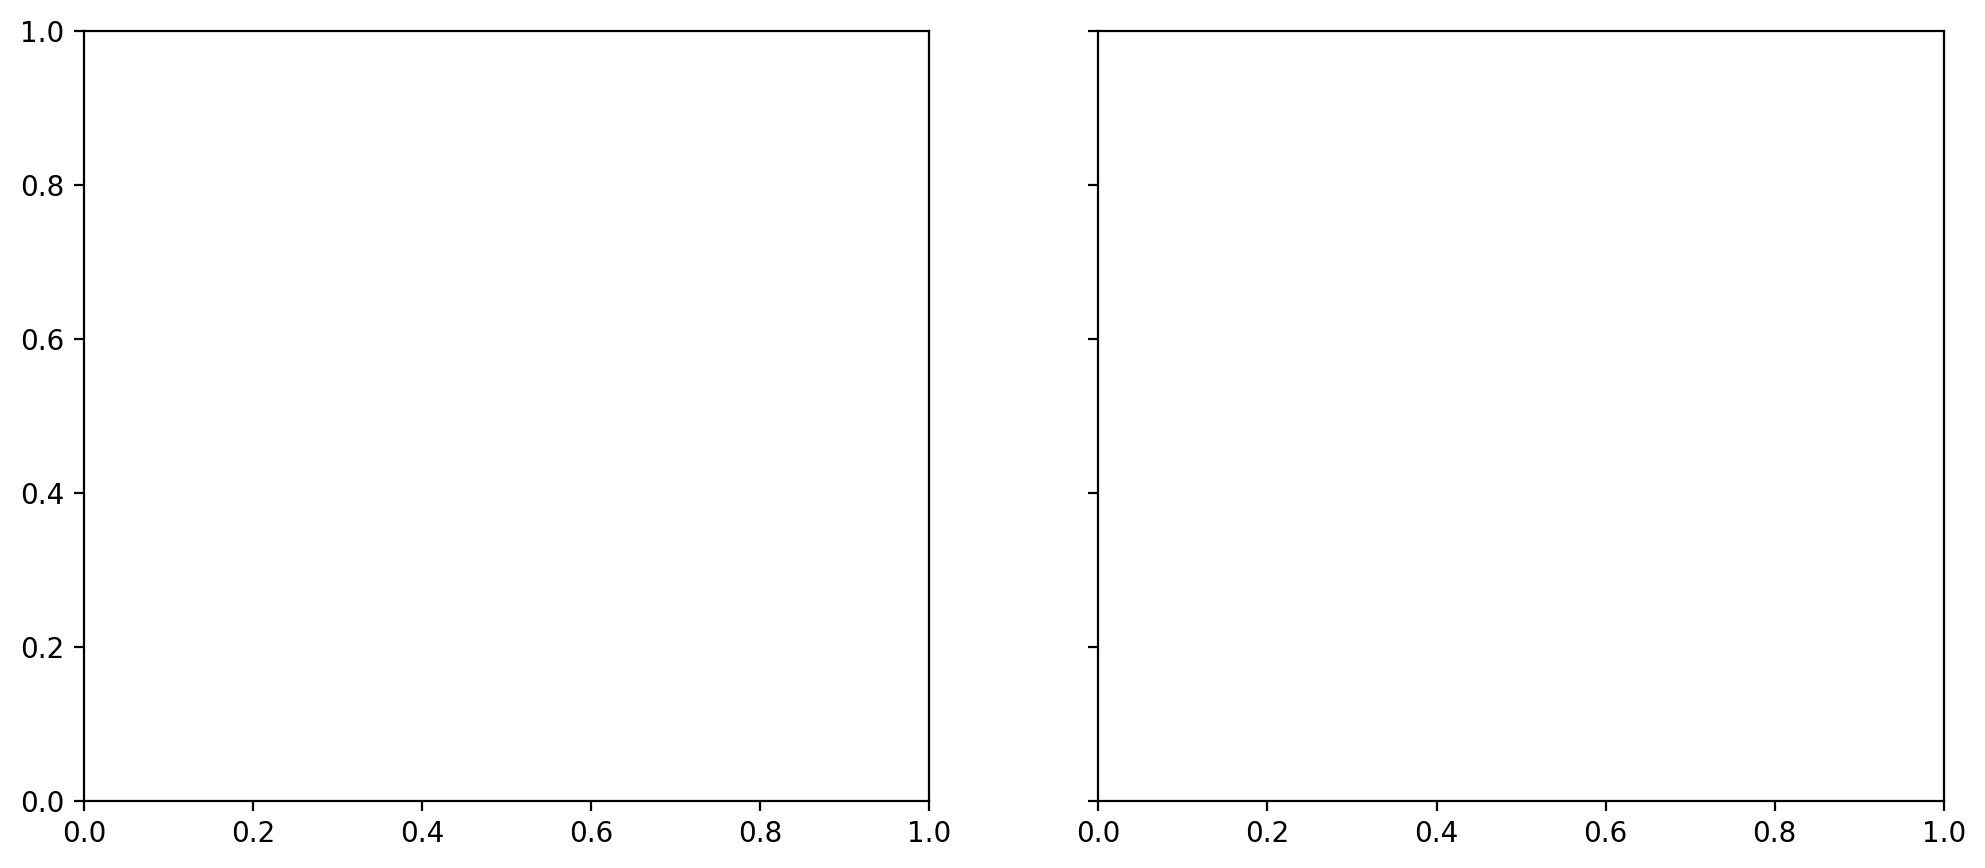

In [10]:
# for "salience_cfg0" and "seq_sft", plot total_compute versus num_oracle, num_oracle + num_weak

fig, axs = plt.subplots(1, 2, figsize=(12, 5), sharey=True, dpi=200)   
plt.sca(axs[0])
plot_df = results_df[results_df["sweep_name"] == "seq_sft"].copy()
plot_df["num_weak_plus_oracle"] = plot_df["num_weak"] + plot_df["num_oracle"]
sns.scatterplot(x="num_weak_plus_oracle", y="total_compute", data=plot_df, hue="ds_name")
# turn of legend
plt.gca().get_legend().remove()
plt.title("Sequential SFT")
plt.xlabel("num_weak + num_oracle")
plt.sca(axs[1])
plot_df = results_df[results_df["sweep_name"] == "salience_cfg0"].copy()
plot_df["num_weak_plus_oracle"] = plot_df["num_weak"] + plot_df["num_oracle"]
sns.scatterplot(x="num_weak_plus_oracle", y="total_compute", data=plot_df, hue="ds_name")
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.title("CFG0")
plt.xlabel("num_weak + num_oracle")
plt.tight_layout()

# GPR of AUROC on num_weak, num_oracle, and other params for each config

In [11]:
from tqdm import tqdm
from sklearn.exceptions import ConvergenceWarning
import warnings
from sklearn.metrics import explained_variance_score
from sklearn.model_selection import train_test_split

# we consider these datasets to be independent random samples from our population
base_ds_names = ['anli-r2',
 'cola',
 'dream',
 'ethics-deontology',
 'ethics_deontology_excuse_only',
 'ethics-justice',
 'ethics-virtue',
 'ethics-utilitarianism',
 'mc_taco',
 'hellaswag',
 'multirc',
 'openbookqa',
 'paws',
 'piqa',
 'quail',
 'quartz',
 'social_i_qa',
 'sst2',
 'wic',
 'twitter-sentiment',
 'sciq',
 'anthropic_hh',
 'cosmos_qa',
 'boolq',
 'amazon_polarity',
]

df["base_ds_name"] = df["ds_name"].apply(lambda x: [name for name in base_ds_names if name in x][0])
results = []
gp_models = []
for sweep_name in ["seq_sft"]: #, "salience_cfg0"]:
    # fix the length scale to avoid overfitting
    kernel = 1.0 * RBF(length_scale=1.0, length_scale_bounds="fixed") + WhiteKernel(noise_level=0.1)
    gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=2, normalize_y=True)

    try:
        with warnings.catch_warnings():
            warnings.filterwarnings("ignore", category=ConvergenceWarning)
            # Perform k-fold cross-validation
            k = 5
            cv_scores = []
            for i in range(k):
                
                curr_df = df[df["sweep_name"] == sweep_name]
                # use a random subset of ds_names as a fold
                unq_ds_names = curr_df["base_ds_name"].unique()
                np.random.shuffle(unq_ds_names)
                train_ds_names = unq_ds_names[:-(len(unq_ds_names) // k)]
                curr_df_train = curr_df[curr_df["base_ds_name"].isin(train_ds_names)]   
                curr_df_held_out = curr_df[~curr_df["base_ds_name"].isin(train_ds_names)]
    
                covariates = ["logp1_num_weak", "logp1_num_oracle", "weak_label_auroc", "salience_weak", "salience_oracle",]
                X_train = (np.stack([curr_df_train[c].values for c in covariates], axis=1))  # type: ignore
                X_held_out = (np.stack([curr_df_held_out[c].values for c in covariates], axis=1))  # type: ignore
                y_train = curr_df_train["auroc"]
                y_held_out = curr_df_held_out["auroc"]

                X_bar = np.mean(X_train, axis=0)
                X_std = np.std(X_train, axis=0)
                def normalize_x(X):
                    return (X - X_bar) / X_std

                # NOTE: we're adding fake training data to encourage the GP to output 0.5 by when there's no data
                n_synth = 100
                X_synth = X_train[np.random.choice(X_train.shape[0], n_synth, replace=False)]
                X_synth[:, 0] = 0
                X_synth[:, 1] = 0
                X_train = np.vstack([X_synth, X_train])
                y_train = np.hstack([np.ones(n_synth) / 2, y_train])
                
                # Fit the GP model on the training data
                # fit re-initializes the GP each time so it's not cheating
                gp.fit(normalize_x(X_train), y_train)
                
                # Predict on held-out data
                y_pred = gp.predict(normalize_x(X_held_out))
                
                # Calculate explained variance for this fold
                fold_explained_variance = explained_variance_score(y_held_out, y_pred)
                cv_scores.append(fold_explained_variance)
                
                # Print progress
                print(f"Fold {i+1}/{k} - Explained variance: {fold_explained_variance:.4f}")
                
                # Store the last fold's data for later use
                if i == k-1:
                    final_X_train, final_X_held_out = X_train, X_held_out
                    final_y_train, final_y_held_out = y_train, y_held_out
            
            print(f"Explained variance for {sweep_name}: {np.mean(cv_scores):.4f} ± {np.std(cv_scores):.4f}")
        

    except Exception as e:
        print(f"Error for {sweep_name}: {str(e)}")
        print("X.shape", X.shape)
        continue

    row_data = {
        "sweep_name": sweep_name,
        "mean_explained_variance": np.mean(cv_scores),
        "std_explained_variance": np.std(cv_scores),
        "explained_variances": cv_scores,
    }
    gp_models.append({
        "gp": gp,
        "X_bar": X_bar,
        "X_std": X_std,
        "X": X,
        "y": y,
        **row_data,
    })


NameError: name 'df' is not defined

In [12]:
held_out_ds_names = set(unq_ds_names) - set(train_ds_names)
train_ds_names, held_out_ds_names

NameError: name 'unq_ds_names' is not defined

In [13]:
plt.scatter(y_held_out, y_pred)
plt.plot([0.8, 1], [0.8, 1], color='k', linestyle='--')
plt.xlabel("True AUROC")
plt.ylabel("Predicted AUROC")
plt.title("Predicted AUROC for Sequential SFT")
plt.show()

NameError: name 'y_held_out' is not defined

# Get all the results interpolated over num weak and num oracle

In [87]:
# for what values of weak affordable, oracle affordable, weak quality, distractor salience, desired salience should you spend 100% of your budget on oracle labels?
# for this I need to:
#  - take each setting (ds_name; including runs with both configs) and compute the GPR fit
#  - choose a few reasonable values of weak affordable and oracle affordable
#  - sample a few AUROCs from the GP for each pair of weak affordable and oracle affordable for each num oracle 
#  - also get the means (store the samples and means in a dataframe)
#  - if exclusively using oracle labels has a higher mean AUROC than any other fraction, then we consider this optimal

In [16]:
from typing import Literal
from scipy import stats
import numpy as np

def sigmoid_sparse_range(start, end, approx_num_points):
    """
    We use this to sample numbers of points because we want more precision near the boundaries 
    where n_weak or n_oracle is small
    """
    def sigmoid(x):
        return 1 / (1 + np.exp(-x))
    
    assert int(start) == start and int(end) == end, f"{start} and {end} must be integers"

    # Generate evenly spaced points in the range [-6, 6]
    x = np.linspace(-7, 7, approx_num_points)

    # Apply sigmoid function
    y = sigmoid(x)

    # Scale to desired range
    scaled = y * (end - start) + start

    # Round to nearest integer and remove duplicates
    result = np.unique(np.round(scaled).astype(int))

    # Ensure start and end are included
    if result[0] != start:
        result = np.insert(result, 0, start)
    if result[-1] != end:
        result = np.append(result, end)

    return result


def get_optimal_spending_frac(gp, weak_affordable=10_000, oracle_marginal_cost=10_000, oracle_fixed_cost=0, objective: Literal["mean", "10th"] = "mean"):
    n_wo = []
    for n_weak in sigmoid_sparse_range(0, round(weak_affordable), 20):
        n_oracle = max(int((weak_affordable - n_weak - oracle_fixed_cost) / oracle_marginal_cost), 0)
        n_wo.append([n_weak, n_oracle])
    n_wo = np.array(n_wo)
    
    # note that it doesn't make sense to sample and then take argmaxes, 
    # because it heavily depends on variance and n
    auroc, auroc_std = gp.predict(reparametrize(n_wo), return_std=True)
    spent_oracle = n_wo[:, 1] * oracle_marginal_cost + np.where(n_wo[:, 1] > 0, oracle_fixed_cost, 0)
    spent_weak = n_wo[:, 0]
    # silence divide by 0 warnings
    with np.errstate(divide='ignore', invalid='ignore'):
        oracle_spending_fracs = np.where(spent_oracle + spent_weak > 0, spent_oracle / (spent_oracle + spent_weak), 0)
    if objective == "mean":
        optimal_spending_frac = oracle_spending_fracs[np.nanargmax(auroc)]
    elif objective == "10th":
        # we want a high bound on the 10th percentile of the distribution
        tenth_percentiles = [stats.norm.ppf(0.1, loc=mu, scale=std) for mu, std in zip(auroc, auroc_std)]
        optimal_spending_frac = oracle_spending_fracs[np.nanargmax(tenth_percentiles)]
    else:
        raise ValueError(f"Unknown objective: {objective}")
    return optimal_spending_frac
        

result = sigmoid_sparse_range(0, int(1e2), 20)
print(result)

[  0   1   2   4   7  14  25  41  59  75  86  93  96  98  99 100]


In [17]:
salience_df = get_salience_df(models=None, ds_names=None, name="results/salienceV2.json")
results_df = get_results_df(ds_names=None, patterns=["nw*_seq_sft_both_estop_s*",])

In [20]:
from tqdm import tqdm
from sklearn.exceptions import ConvergenceWarning
import warnings

gp_models = []
for row_name in tqdm(results_df.index.unique(), total=len(results_df.index.unique())):
    for sweep_name in ["seq_sft_both_estop"]:

        ds_name, model_name, _ = row_name
        curr_df = results_df[(results_df["ds_name"] == ds_name) & (results_df["model_name"] == model_name) & (results_df["sweep_name"] == sweep_name)]
        if len(curr_df) == 0:
            continue
        X_raw = np.stack([curr_df["num_weak"].values, curr_df["num_oracle"].values], axis=1)
        # we didn't actually run this run, but we know that if you train on 0 data you'd get 0.5 AUROC on average and we want our GP to reflect that
        X_raw = np.vstack([X_raw, np.zeros((1, 2))])
        X = reparametrize(X_raw)  # type: ignore
        y = curr_df["auroc"].values
        y = np.hstack([y, np.ones(1) / 2])

        kernel = 1.0 * RBF(length_scale=1.0, length_scale_bounds="fixed") + WhiteKernel(noise_level=0.1)
        gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=2, normalize_y=True)

        gp.fit(X, y)
        # try:
        #     with warnings.catch_warnings():
        #         warnings.filterwarnings("error")
        #         gp.fit(X, y)
        # except ConvergenceWarning:
        #     print(f"ConvergenceWarning for {ds_name} {model_name} {sweep_name}")
        #     print("X.shape", X.shape)
        #     continue

        row_data = {
            "ds_name": ds_name,
            "model_name": model_name,
            # "weak_label_auroc": row["weak_label_auroc"],
            # "weak_label_acc": row["weak_label_acc"],
            # "salience_weak": row["salience_weak"],
            # "salience_oracle": row["salience_oracle"],
            "sweep_name": sweep_name,
        }
        gp_models.append({
            "gp": gp,
            "X": X,
            "y": y,
            **row_data,
        })

    # if ds_name == "ethics-utilitarianism_Qwen1.5-0.5B" and len(curr_df) > 0:
        # break
        
gp_models = pd.DataFrame(gp_models).set_index(["ds_name", "model_name", "sweep_name"])


  0%|          | 0/60 [00:00<?, ?it/s]/home/alex/.conda/envs/w2s2/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/alex/.conda/envs/w2s2/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/alex/.conda/envs/w2s2/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
  5%|▌     

In [8]:
# all_df.to_pickle("results/optimal_spending_frac.pkl")
# gp_models.to_pickle("results/gp_models.pkl")

# Get a heatmap of optimal spending fraction
versus weak affordable and oracle marginal cost for each dataset, model, and oracle fixed cost

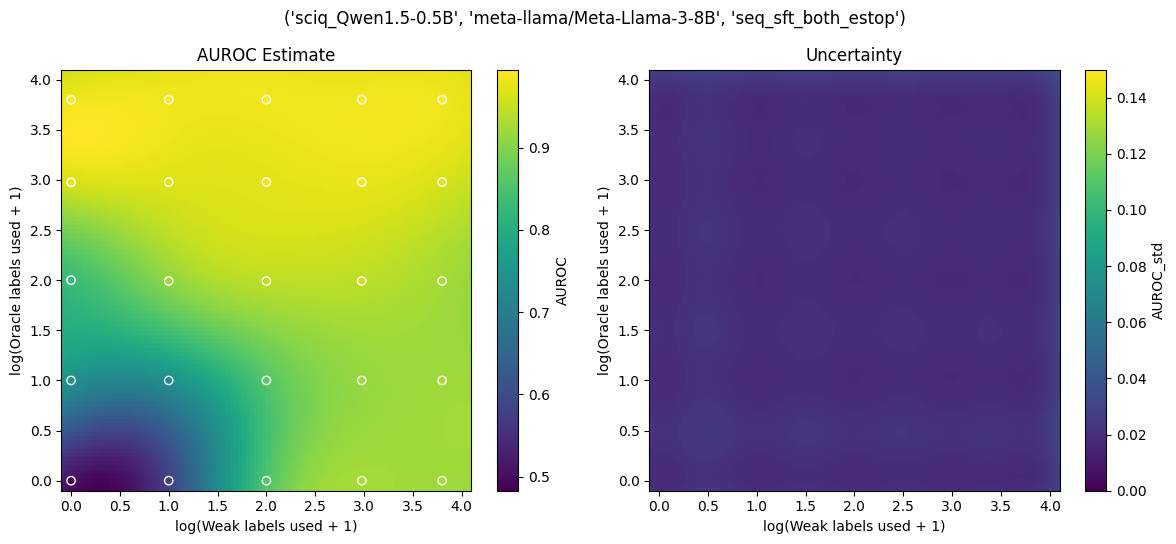

In [45]:
from matplotlib.colors import Normalize

# Create a grid for prediction
# ds_name = 'boolq_Qwen1.5-0.5B'
# ds_name = 'boolq_Qwen1.5-0.5B_shuffled_err'
# ds_name = "amazon_polarity_Qwen1.5-0.5B"
# ds_name = "amazon_polarity_Qwen1.5-0.5B_shuffled_err"
ds_name = "sciq_Qwen1.5-0.5B"
# ds_name = "sciq_Qwen1.5-0.5B_shuffled_err"
row_name = run_name = (ds_name,
  'meta-llama/Meta-Llama-3-8B',
  'seq_sft_both_estop')
row = gp_models.loc[row_name]
X, y, gp = row["X"], row["y"], row["gp"]
x_range = np.linspace(-0.1, 4.1, 100)
y_range = np.linspace(-0.1, 4.1, 100)
xx, yy = np.meshgrid(x_range, y_range)
Xgrid = np.vstack([xx.ravel(), yy.ravel()]).T

# Predict on the grid
Z, Z_std = gp.predict(Xgrid, return_std=True)  # type: ignore
Z, Z_std = Z.reshape(xx.shape), Z_std.reshape(xx.shape)

# Plot
fig, axs = plt.subplots(1, 2, figsize=(12, 5.5))
ax = axs[0]
im = ax.imshow(Z, extent=[x_range.min(), x_range.max(), y_range.min(), y_range.max()],
               origin='lower', aspect='auto', cmap='viridis')
ax.scatter(X[:, 0], X[:, 1], c=y, cmap='viridis', edgecolors='w')
plt.colorbar(im, label='AUROC')
ax.set_xlabel(reparam.format(x="Weak labels used"))
ax.set_ylabel(reparam.format(x="Oracle labels used"))
ax.set_title("AUROC Estimate")
ax = axs[1]
im = ax.imshow(Z_std, extent=[x_range.min(), x_range.max(), y_range.min(), y_range.max()],
               origin='lower', aspect='auto', cmap='viridis', norm=Normalize(0, 0.15))
plt.colorbar(im, label='AUROC_std')
ax.set_xlabel(reparam.format(x="Weak labels used"))
ax.set_ylabel(reparam.format(x="Oracle labels used"))
ax.set_title("Uncertainty")
plt.suptitle(f"{row_name}")
plt.tight_layout()
plt.show()

In [46]:
y[(X[:, 0] < 1) & (X[:, 1] >= 2.9)].mean()

0.9756778478622437

In [47]:
y[(X[:, 0] < 1) & (X[:, 1] >= 2.9)].mean()

0.9756778478622437

In [48]:
# makes a plot with 
# x=weak_affordable, y=oracle_affordable, and color=optimal_spending_frac as a heatmap/imshow

# get a grid of weak_affordable and oracle_marginal_cost
oracle_fixed_cost = 0
max_oracle_marginal_cost = 10_000
max_weak_affordable = 10_000
objective = "mean"
results = []
nx, ny = 20, 20
omcs, was = np.geomspace(1, max_oracle_marginal_cost, nx), np.geomspace(1, max_weak_affordable, ny)
grids = dict()
for row in gp_models.iloc:
    grids[row.name] = np.zeros((nx, ny))
    for i, oracle_marginal_cost in enumerate(omcs):
        for j, weak_affordable in enumerate(was):
            optimal_spending_frac = get_optimal_spending_frac(row["gp"], weak_affordable=weak_affordable, oracle_marginal_cost=oracle_marginal_cost, oracle_fixed_cost=oracle_fixed_cost, objective=objective)
            grids[row.name][i, j] = optimal_spending_frac
            results.append({
                "oracle_marginal_cost": oracle_marginal_cost,
                "weak_affordable": weak_affordable,
                "optimal_spending_frac": optimal_spending_frac,
                **row.to_dict(),
            })

heatmap_df = pd.DataFrame(results)


In [49]:
# all_df = pd.read_pickle("results/optimal_spending_frac.pkl")
# gp_models = pd.read_pickle("results/gp_models.pkl")

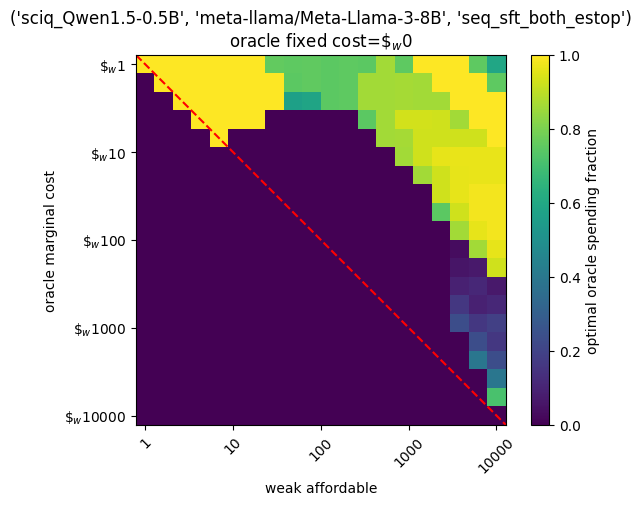

In [50]:
from matplotlib.colors import Normalize
run_name = (ds_name,
  'meta-llama/Meta-Llama-3-8B',
  'seq_sft_both_estop')
plt.imshow(grids[run_name], norm=Normalize(0, 1))
plt.ylabel("oracle marginal cost")

# Select a subset of omcs and was for axis labels
num_ticks = 5
omc_ticks = np.geomspace(omcs[0], omcs[-1], num_ticks)
was_ticks = np.geomspace(was[0], was[-1], num_ticks)
plt.yticks(np.linspace(0, nx-1, num_ticks), [f"$\\$_w${x:.0f}" for x in omc_ticks])
plt.xticks(np.linspace(0, ny-1, num_ticks), [f"{x:.0f}" for x in was_ticks])
plt.xticks(rotation=45)

# draw y = x
plt.plot([-0.5, ny - 0.5], [-0.5, nx - 0.5], c="r", linestyle="--")

plt.title(f"{run_name}\noracle fixed cost=$\\$_w${oracle_fixed_cost}")

plt.xlabel("weak affordable")
plt.colorbar(label="optimal oracle spending fraction")
plt.show()

In [122]:
import matplotlib.pyplot as plt
import numpy as np

def parallel_lines_chart(data, feature_names, class_labels=None, colors=None, jitter=0.):
    """
    Create a parallel lines chart.
    
    :param data: 2D array where each row is an instance and each column a feature
    :param feature_names: List of feature names
    :param class_labels: List of class labels for each instance (optional)
    :param colors: List of colors for each class (optional)
    """
    fig, ax = plt.subplots(figsize=(12, 6))

    # Number of features
    num_features = data.shape[1]

    # Create x-axis points for each feature
    x = list(range(num_features))

    # Plot each instance
    for i, instance in enumerate(data):
        if class_labels is not None and colors is not None:
            color = colors[class_labels[i]]
        else:
            color = 'gray'
        
        jit = np.random.uniform(-jitter, jitter, num_features)
        ax.plot(x, instance + jit, c=color, alpha=0.3)

    # Set x-ticks and labels
    ax.set_xticks(x)
    ax.set_xticklabels(feature_names)
    # rotate
    plt.xticks(rotation=45, ha="right")

    # Set y-axis limits
    ax.set_ylim(data.min().min(), data.max().max())

    # Add a legend if class labels are provided
    if class_labels is not None and colors is not None:
        unique_labels = np.unique(class_labels)
        legend_elements = [plt.Line2D([0], [0], color=colors[label], label=label) 
                           for label in unique_labels]
        ax.legend(handles=legend_elements)

    plt.title('Parallel Lines Chart')
    plt.tight_layout()
    plt.show()

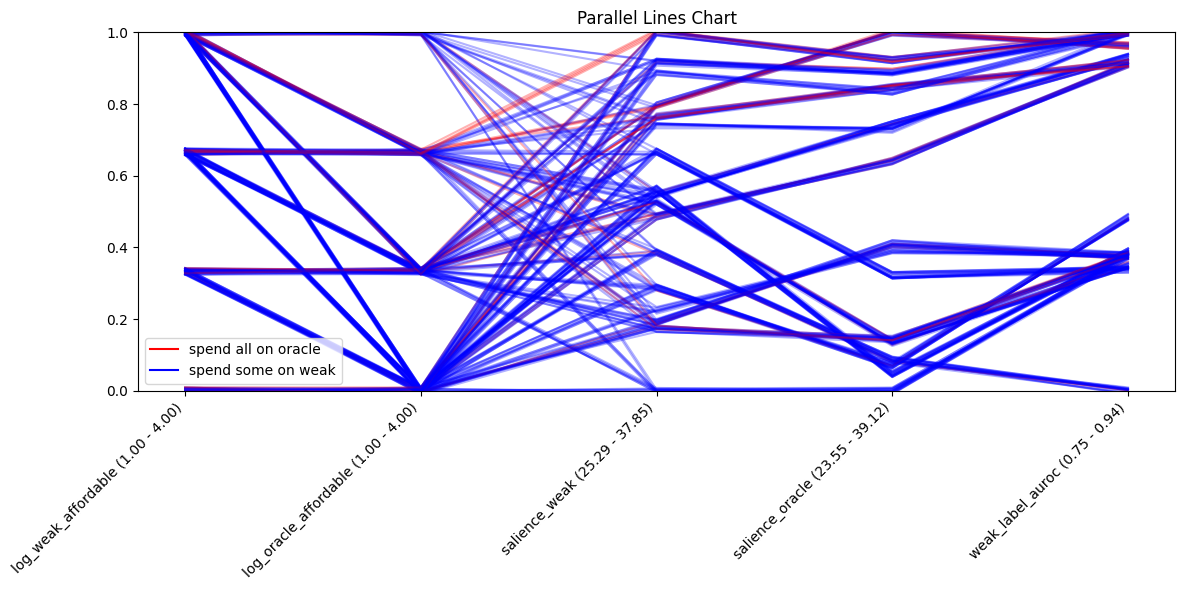

In [350]:
all_df["log_weak_affordable"] = np.log10(all_df["weak_affordable"])
all_df["log_oracle_affordable"] = np.log10(all_df["oracle_affordable"])
features = ["log_weak_affordable", "log_oracle_affordable", "salience_weak", "salience_oracle", "weak_label_auroc"]
data_raw = all_df[features].values
# normalize to [0, 1]
data = (data_raw - data_raw.min(axis=0)) / (data_raw.max(axis=0) - data_raw.min(axis=0))
feature_names = [f"{f} ({d.min():.2f} - {d.max():.2f})" for f, d in zip(features, data_raw.T)]
class_labels = np.where(all_df["optimal_spending_frac"].values == 1, "spend all on oracle", "spend some on weak")
colors = {"spend all on oracle": "red", "spend some on weak": "blue"}
# data = data[class_labels == "spend all on oracle"]
# class_labels = class_labels[class_labels == "spend all on oracle"]

parallel_lines_chart(data, feature_names, class_labels, colors, jitter=0.01)


In [9]:
for lo, up in [(0, 0), (0, 0.1), (0.1, 0.9), (0.9, 1), (1, 1)]:
    print(f"Fraction of runs where optimal oracle spending frac is between {lo} and {up}:")
    print("\t" + str(((all_df["optimal_spending_frac"] <= up) & (all_df["optimal_spending_frac"] >= lo)).mean()))

Fraction of runs where optimal oracle spending frac is between 0 and 0:
	0.2709677419354839
Fraction of runs where optimal oracle spending frac is between 0 and 0.1:
	0.3
Fraction of runs where optimal oracle spending frac is between 0.1 and 0.9:
	0.3258064516129032
Fraction of runs where optimal oracle spending frac is between 0.9 and 1:
	0.3870967741935484
Fraction of runs where optimal oracle spending frac is between 1 and 1:
	0.13870967741935483


In [10]:
sns.scatterplot(x="weak_label_auroc", y="salience_oracle", hue="optimal_spending_frac", data=all_df, palette="viridis")
plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))

NameError: name 'sns' is not defined

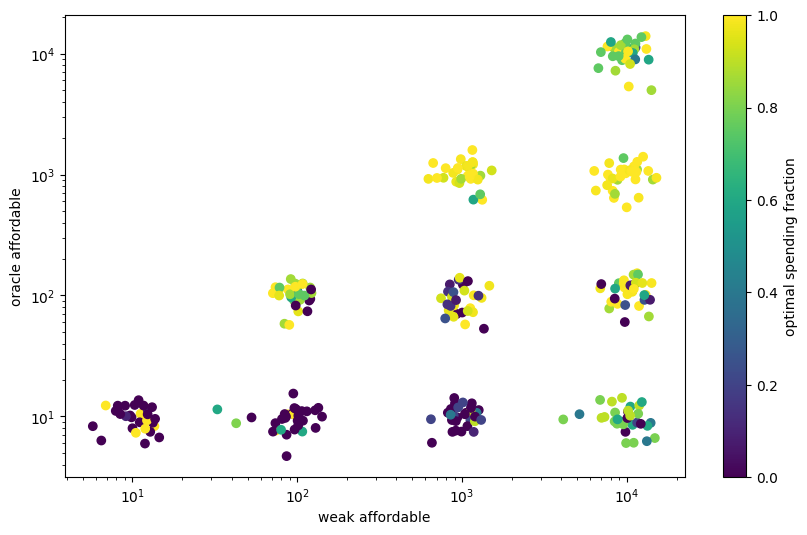

In [11]:

plt.figure(figsize=(10, 6))
# sns.scatterplot(x="weak_affordable", y="oracle_affordable", hue="optimal_spending_frac", data=gb_df, alpha=0.8, palette="viridis")
# plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
jitter = 0.2
jitterx = np.random.normal(0, jitter, len(all_df))
jittery = np.random.normal(0, jitter, len(all_df))
plt.scatter(all_df["weak_affordable"] * (1 + jitterx), all_df["oracle_affordable"] * (1 + jittery), c=all_df["optimal_spending_frac"], cmap="viridis")
plt.colorbar(label="optimal spending fraction")
plt.loglog()
plt.xlabel("weak affordable")
plt.ylabel("oracle affordable")
plt.show()

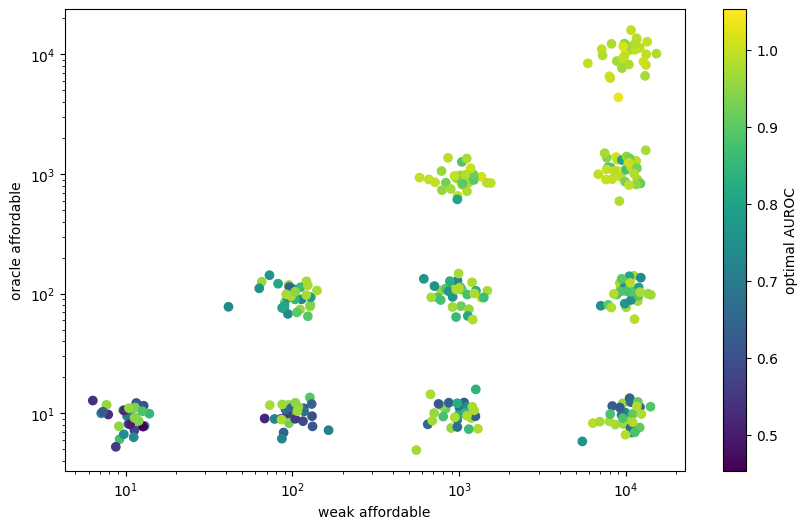

In [12]:
plt.figure(figsize=(10, 6))
# sns.scatterplot(x="weak_affordable", y="oracle_affordable", hue="optimal_spending_frac", data=gb_df, alpha=0.8, palette="viridis")
# plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
jitter = 0.2
jitterx = np.random.normal(0, jitter, len(all_df))
jittery = np.random.normal(0, jitter, len(all_df))
plt.scatter(all_df["weak_affordable"] * (1 + jitterx), all_df["oracle_affordable"] * (1 + jittery), c=all_df["max_auroc"], cmap="viridis")
plt.colorbar(label="optimal AUROC")
plt.loglog()
plt.xlabel("weak affordable")
plt.ylabel("oracle affordable")
plt.show()

Text(0, 0.5, 'oracle salience')

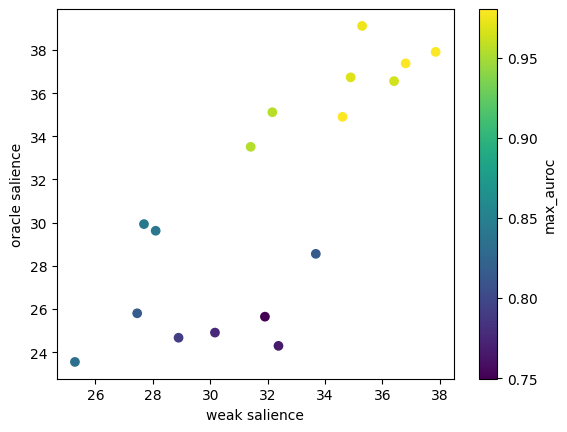

In [14]:
metric = "max_auroc"
gb_df = all_df.groupby(["salience_weak", "salience_oracle"]).mean(numeric_only=True).reset_index()
plt.scatter(gb_df["salience_weak"], gb_df["salience_oracle"], c=gb_df[metric], cmap="viridis")
plt.colorbar(label=metric)
plt.xlabel("weak salience")
plt.ylabel("oracle salience")


                              OLS Regression Results                             
Dep. Variable:     optimal_spending_frac   R-squared:                       0.317
Model:                               OLS   Adj. R-squared:                  0.306
Method:                    Least Squares   F-statistic:                     28.26
Date:                   Fri, 12 Jul 2024   Prob (F-statistic):           1.64e-23
Time:                           21:06:21   Log-Likelihood:                -114.60
No. Observations:                    310   AIC:                             241.2
Df Residuals:                        304   BIC:                             263.6
Df Model:                              5                                         
Covariance Type:               nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------


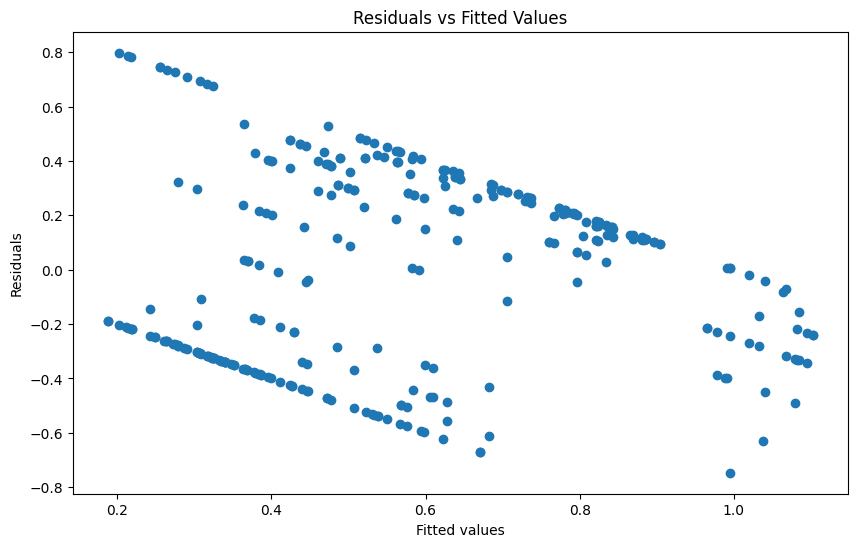

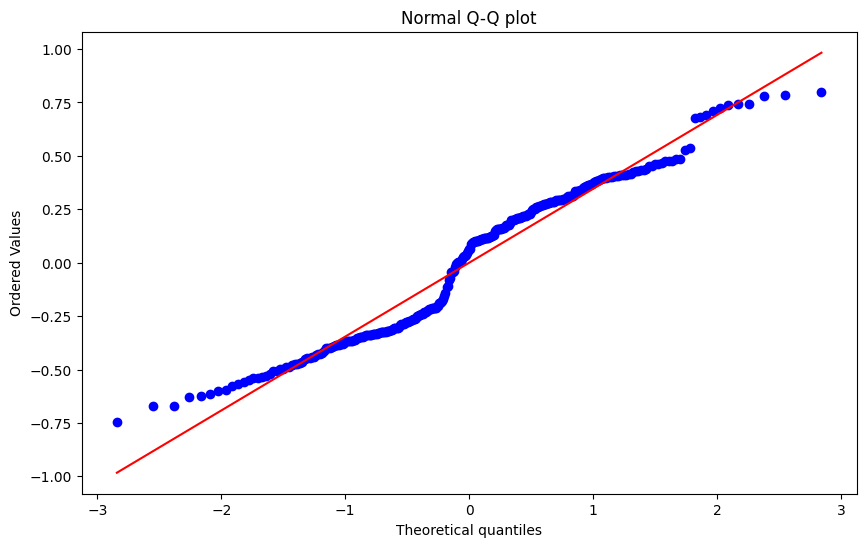


Sklearn Coefficients:
weak_label_auroc: -0.42286562396919747
log_weak_affordable: 0.06052990892812045
log_oracle_affordable: 0.19837464888075546
salience_weak: 0.019005950841248186
salience_oracle: -0.004963735043528768


In [16]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import scipy.stats as stats

# Assuming all_df is your DataFrame
# If it's not defined, you need to load your data into all_df

# Prepare the data
X = all_df[["weak_label_auroc", "log_weak_affordable", "log_oracle_affordable", "salience_weak", "salience_oracle"]]
# X = all_df[["weak_label_auroc", "log_weak_affordable", "log_oracle_affordable", "salience_weak", "salience_oracle"]]
y = all_df["optimal_spending_frac"]

# Statsmodels regression (for detailed statistics)
X_sm = sm.add_constant(X)  # Add a constant term to the independent variables
model = sm.OLS(y, X_sm).fit()

# Print the summary of the regression
print(model.summary())

# Calculate VIF for each independent variable
vif_data = pd.DataFrame()
vif_data["Variable"] = X_sm.columns
vif_data["VIF"] = [variance_inflation_factor(X_sm.values, i) for i in range(X_sm.shape[1])]
print("\nVariance Inflation Factors:")
print(vif_data)

# Residual analysis
residuals = model.resid
fitted_values = model.fittedvalues

# Plot residuals vs fitted values
plt.figure(figsize=(10, 6))
plt.scatter(fitted_values, residuals)
plt.xlabel('Fitted values')
plt.ylabel('Residuals')
plt.title('Residuals vs Fitted Values')
plt.show()

# Normal Q-Q plot of residuals
fig, ax = plt.subplots(figsize=(10, 6))
stats.probplot(residuals, dist="norm", plot=ax)
ax.set_title("Normal Q-Q plot")
plt.show()

# Sklearn regression (for coefficients)
lr = LinearRegression()
lr.fit(X, y)
print("\nSklearn Coefficients:")
for name, coef in zip(X.columns, lr.coef_):
    print(f"{name}: {coef}")

LinregressResult(slope=-0.04100477511584464, intercept=0.6152443692844544, rvalue=-0.005705611629081233, pvalue=0.9203025276557919, stderr=0.40949612869790186, intercept_stderr=0.3557231747599607)

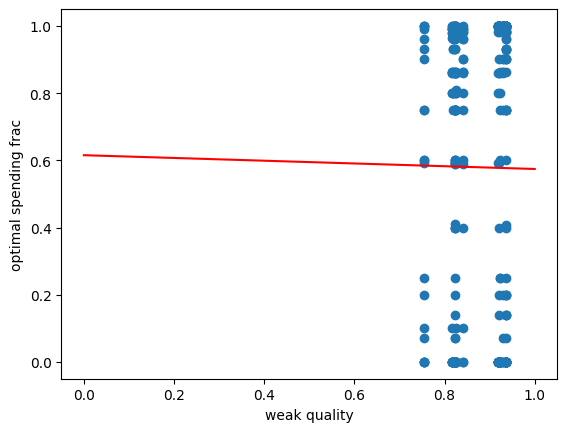

In [165]:
# linear regressiong of optimal spending frac on weak quality
l = linregress(all_df["weak_label_auroc"], all_df["optimal_spending_frac"])
plt.scatter(all_df["weak_label_auroc"], all_df["optimal_spending_frac"])
plt.plot([0, 1], [l.intercept, l.intercept + l.slope], color="red")

plt.xlabel("weak quality")
plt.ylabel("optimal spending frac")
l

## Cross-sectional results

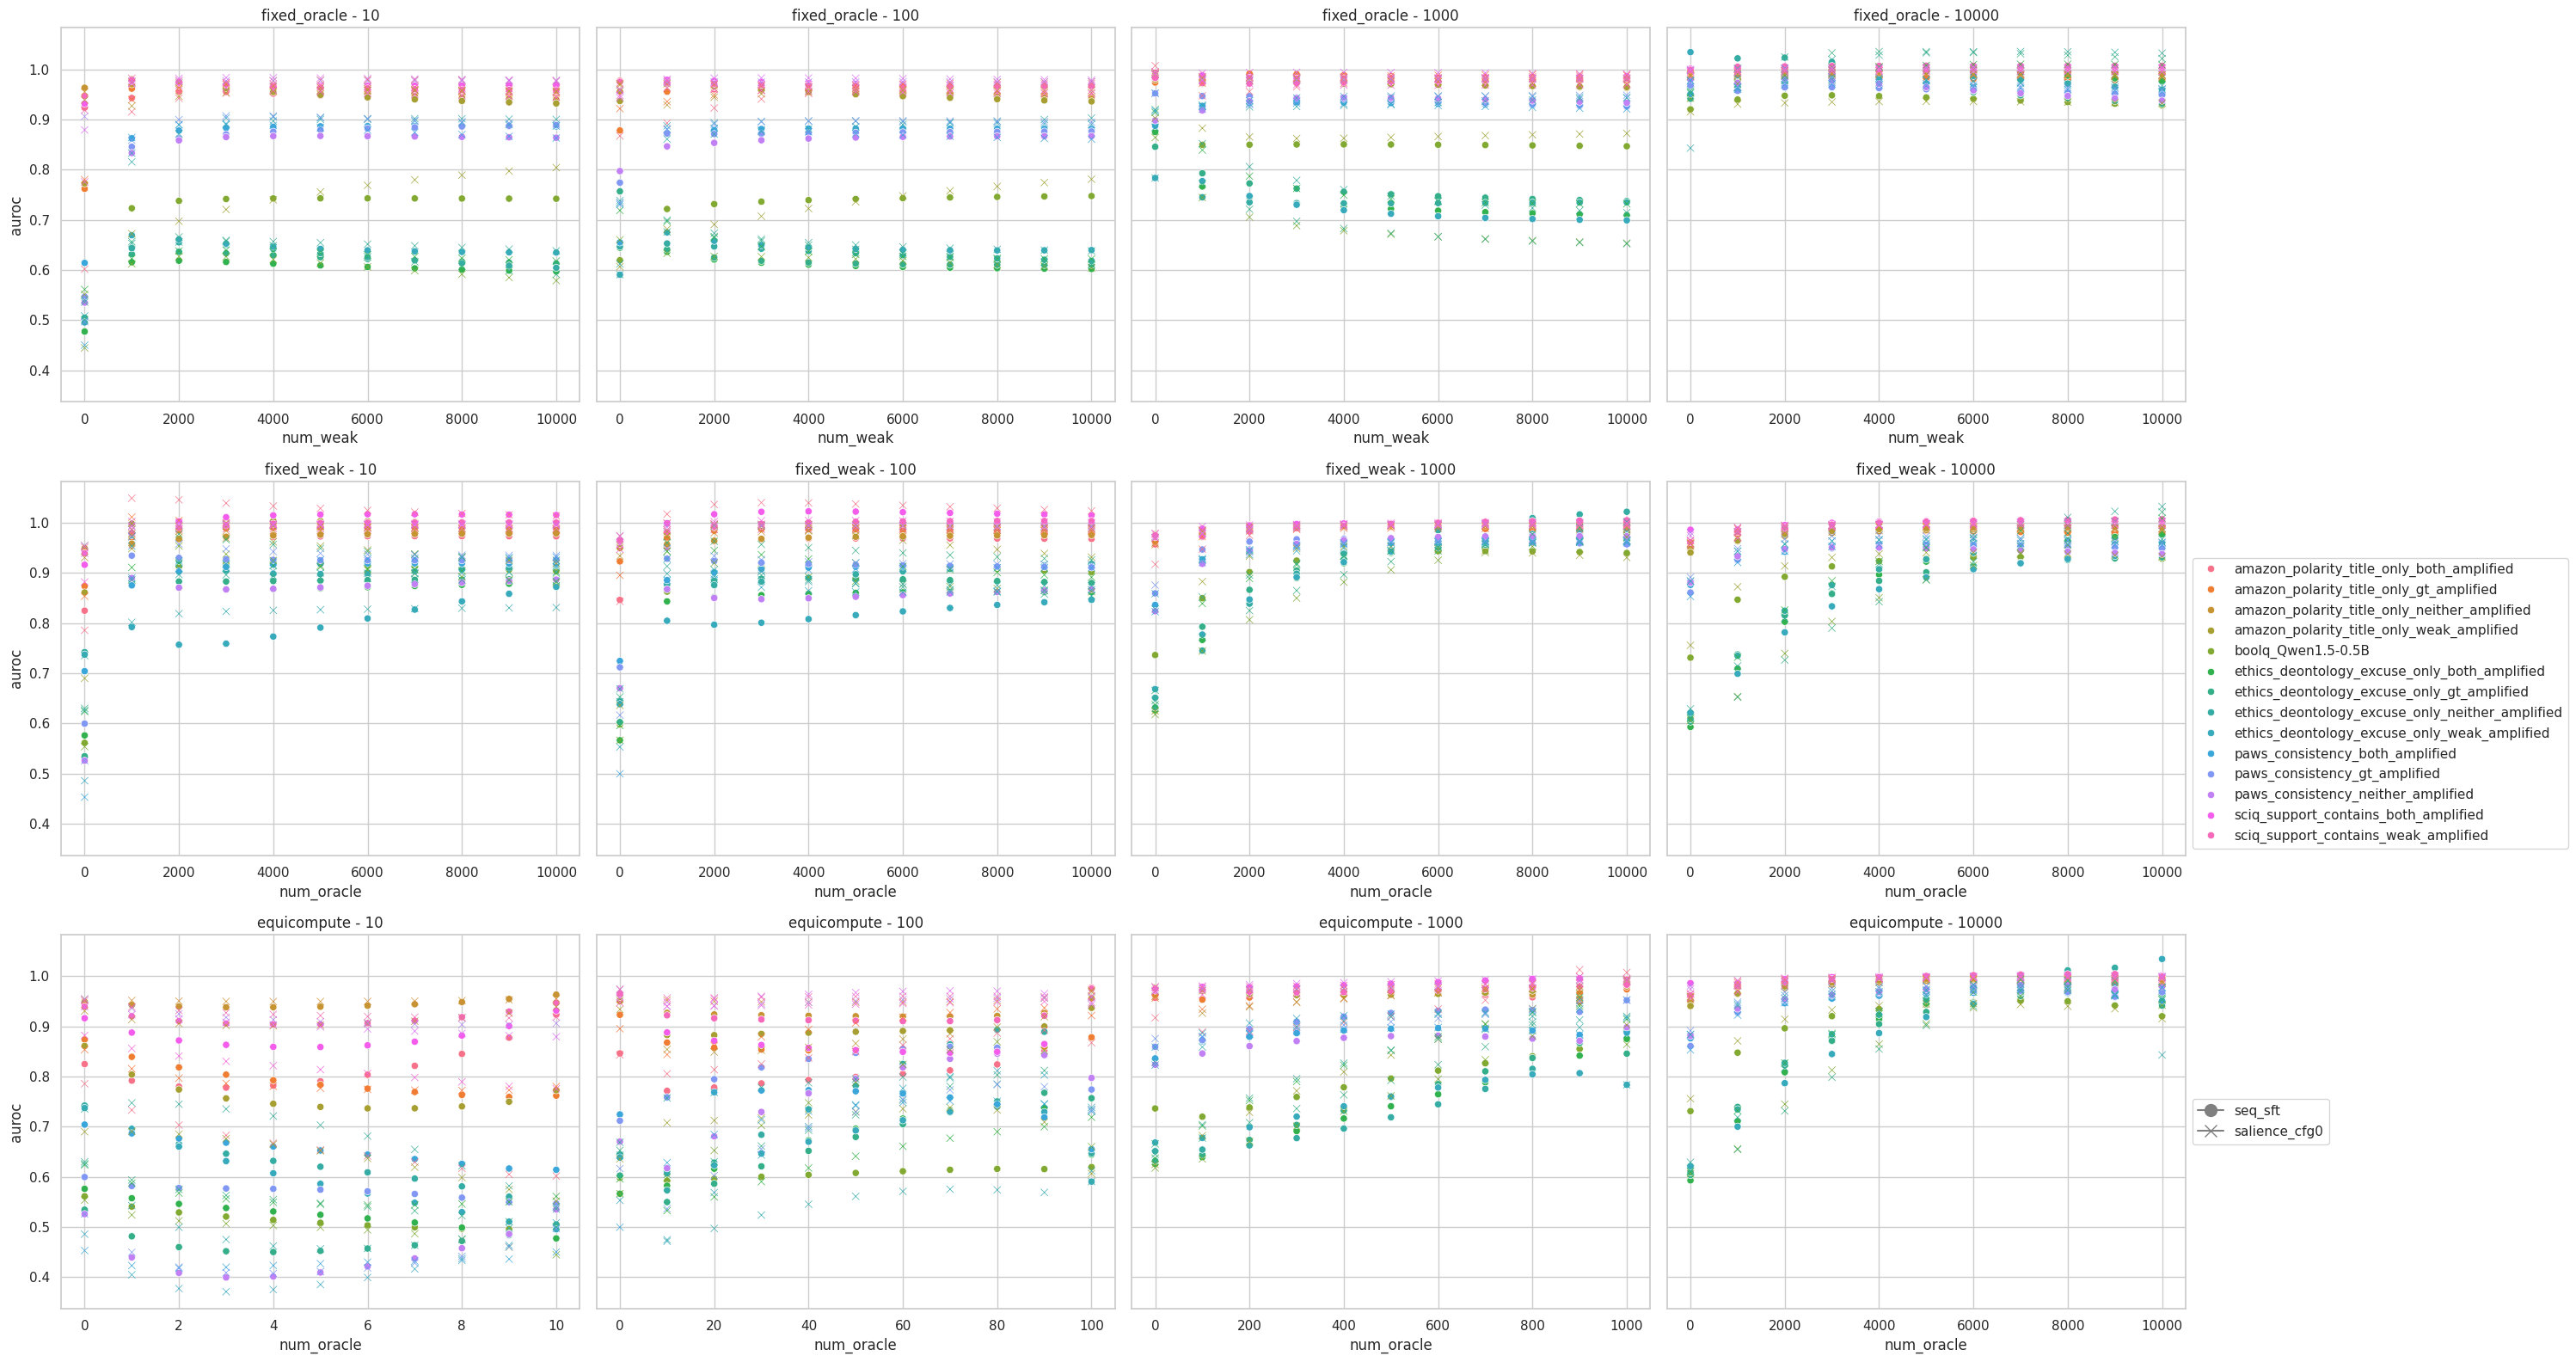

In [174]:
from typing import Literal
from collections import defaultdict

def get_cross_sectional_results(gp_df, kind: Literal["fixed_oracle", "fixed_weak", "equicompute"], intercept: int, n_samples=11):
    results = defaultdict(list)
    for row in gp_df.iloc:
        if kind == "fixed_oracle":
            n_wo = np.stack([np.linspace(0, 1e4, n_samples), np.array([intercept] * n_samples)], axis=1)
        elif kind == "fixed_weak":
            n_wo = np.stack([np.array([intercept] * n_samples), np.linspace(0, 1e4, n_samples)], axis=1)
        elif kind == "equicompute":
            n_wo = np.stack([np.linspace(0, intercept, n_samples), np.linspace(intercept, 0, n_samples)], axis=1)
        else:
            raise ValueError(f"Unknown kind: {kind}")

        mean, std = row["gp"].predict(reparametrize(n_wo), return_std=True)
        results["ds_name"].extend([row["ds_name"]] * n_samples)
        results["model_name"].extend([row["model_name"]] * n_samples)
        results["kind"].extend([kind] * n_samples)
        results["sweep_name"].extend([row["sweep_name"]] * n_samples)
        results["intercept"].extend([intercept] * n_samples)
        results["num_weak"].extend(n_wo[:, 0])
        results["num_oracle"].extend(n_wo[:, 1])
        results["auroc"].extend(mean)
        results["auroc_std"].extend(std)

    return pd.DataFrame(results)
    
sns.set_theme(style="whitegrid")
fig, axs = plt.subplots(3, 4, figsize=(30, 16), sharey=True, sharex=False)
for i, kind in enumerate(["fixed_oracle", "fixed_weak", "equicompute"]):
    for j, intercept in enumerate([10, 100, 1000, 10_000]):
        df = get_cross_sectional_results(gp_models, kind, intercept)
        plt.sca(axs[i, j])
        for sweep_name in ["seq_sft", "salience_cfg0"]:
            plot_df = df[df["sweep_name"] == sweep_name]
            sns.scatterplot(x="num_weak" if kind == "fixed_oracle" else "num_oracle", y="auroc", hue="ds_name", data=plot_df, marker="o" if sweep_name == "seq_sft" else "x", legend=i == 1 and j == 3 and sweep_name == "seq_sft")
            if i == 1 and j == 3 and sweep_name == "seq_sft":
                plt.legend(bbox_to_anchor=(1,0), loc="lower left", ncol=1)
        
        
        axs[i, j].set_title(f"{kind} - {intercept}")
# Add legend entries for x and o markers
legend_elements = [
    plt.Line2D([0], [0], marker='o', color='gray', label='seq_sft', markerfacecolor='gray', markersize=10),
    plt.Line2D([0], [0], marker='x', color='gray', label='salience_cfg0', markerfacecolor='gray', markersize=10)
]

# Add the legend to the last subplot
axs[-1, -1].legend(handles=legend_elements, loc='center left', bbox_to_anchor=(1, 0.5))

# Adjust the layout to make room for the legend
plt.tight_layout()
fig.subplots_adjust(right=0.85)

plt.show()

In [63]:
plot_df

,ds_name,model_name,kind,sweep_name,intercept,num_weak,num_oracle,auroc,auroc_std
1001,amazon_polarity_title_only_both_amplified,meta-llama/Meta-Llama-3-8B,fixed_oracle,salience_cfg0,1000,0.0,1000.0,0.935998,0.121226
1002,amazon_polarity_title_only_both_amplified,meta-llama/Meta-Llama-3-8B,fixed_oracle,salience_cfg0,1000,10.0,1000.0,0.935998,0.121226
1003,amazon_polarity_title_only_both_amplified,meta-llama/Meta-Llama-3-8B,fixed_oracle,salience_cfg0,1000,20.0,1000.0,0.935998,0.121226
1004,amazon_polarity_title_only_both_amplified,meta-llama/Meta-Llama-3-8B,fixed_oracle,salience_cfg0,1000,30.0,1000.0,0.935998,0.121226
1005,amazon_polarity_title_only_both_amplified,meta-llama/Meta-Llama-3-8B,fixed_oracle,salience_cfg0,1000,40.0,1000.0,0.935998,0.121226
...,...,...,...,...,...,...,...,...,...
33028,sciq_support_contains_weak_amplified,meta-llama/Meta-Llama-3-8B,fixed_oracle,salience_cfg0,1000,9960.0,1000.0,0.975917,0.023188
33029,sciq_support_contains_weak_amplified,meta-llama/Meta-Llama-3-8B,fixed_oracle,salience_cfg0,1000,9970.0,1000.0,0.975917,0.023188
33030,sciq_support_contains_weak_amplified,meta-llama/Meta-Llama-3-8B,fixed_oracle,salience_cfg0,1000,9980.0,1000.0,0.975917,0.023188
33031,sciq_support_contains_weak_amplified,meta-llama/Meta-Llama-3-8B,fixed_oracle,salience_cfg0,1000,9990.0,1000.0,0.975917,0.023188


# Equi-cost curves

In [ ]:
df = None

0.0
0.5000000000000001
1.0


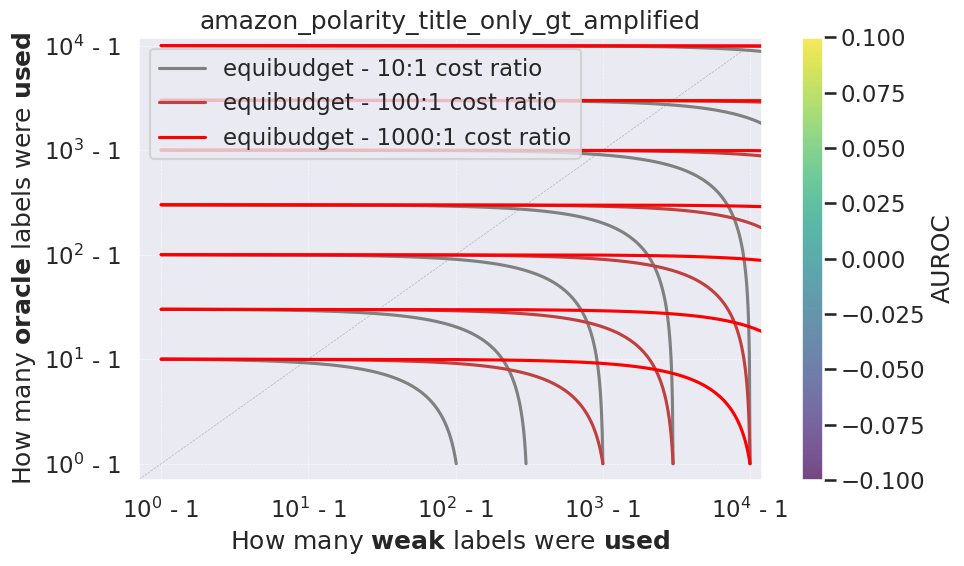

In [248]:
import numpy as np
from matplotlib.colors import Normalize, LinearSegmentedColormap
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 6))

# ds_name = "boolq_Qwen1.5-0.5B"
ds_name = "amazon_polarity_title_only_gt_amplified"
plot_df = df[df["ds_name"] == ds_name]
min_auroc = round(plot_df["auroc"].quantile(0.25), 2)
max_auroc = round(plot_df["auroc"].max(), 2)
# Create a scatter plot with total_spent on x-axis and oracle_cost on y-axis
jitter = 0.0
norm = Normalize(vmin=min_auroc, vmax=max_auroc)
colors = plt.cm.viridis(np.linspace(0, 1, 256))
n_bins = 256
cmap = LinearSegmentedColormap.from_list('custom_cmap', colors, N=n_bins)
cmap.set_under('black')
scatter = ax.scatter((plot_df['num_weak'] + 1) * np.random.normal(1, jitter, len(plot_df)), (plot_df['num_oracle'] + 1) * np.random.normal(1, jitter, len(plot_df)), c=plot_df['auroc'], cmap=cmap, s=100, norm=norm, alpha=0.7)
plt.plot([0, 9000], [0, 9000], color="gray", linestyle="--", alpha=0.5, linewidth=0.5)

cmap = LinearSegmentedColormap.from_list('gray_to_red', ["gray", "red"], N=256)
crs = [10, 100, 1000]
for cost_ratio in crs:
    # color should be near gray if log(cr) is small, and near red if log(cr) is large
    color = (np.log(cost_ratio) - min(map(np.log, crs))) / (max(map(np.log, crs)) - min(map(np.log, crs))) 
    print(color)
    color = cmap(color)
    for oint in [10, 30, 100, 300, 1000, 3000, 10_000]:
        plt.plot(np.linspace(oint * cost_ratio + 1, 1, 101), np.linspace(1, oint, 101), color=color, linestyle="-", label=f"equibudget - {cost_ratio}:1 cost ratio" if oint == 10 else None)
plt.legend()

# Set labels and title
ax.set_xlabel("How many $\\bf{weak}$ labels were $\\bf{used}$")
ax.set_ylabel("How many $\\bf{oracle}$ labels were $\\bf{used}$")
ax.set_title(f"{ds_name}")

plt.loglog()
# replace tick labels with 10^i - 1
ticks = [1, 10, 100, 1000, 10000]
ax.set_xticks(ticks)
ax.set_yticks(ticks)
ax.set_xticklabels([f"$10^{int(np.log10(tick))}$ - 1" for tick in ticks])
ax.set_yticklabels([f"$10^{int(np.log10(tick))}$ - 1" for tick in ticks])
ax.set_xlim(0.7, 12_000)
ax.set_ylim(0.7, 12_000)

cbar = plt.colorbar(scatter)
cbar.set_label('AUROC')

ax.grid(True, linestyle='--', alpha=0.7, linewidth=0.5)

plt.tight_layout()
plt.show()


# Quantization

In [29]:
import wandb
import pandas as pd 
import wandb
api = wandb.Api()

# Project is specified by <entity/project-name>
runs = api.runs("eleutherai/huggingface")
runs_by_name = {run.name: run for run in runs}

run_names = [
    "amazon_polarity_Meta-Llama-3-8B_s1_quant",
    "amazon_polarity_Meta-Llama-3-8B_s1",
    "boolq_Meta-Llama-3-8B_s1_quant",
    "boolq_Meta-Llama-3-8B_s1",
    "amazon_polarity_Meta-Llama-3-8B_s2_quant",
    "amazon_polarity_Meta-Llama-3-8B_s2",
    "boolq_Meta-Llama-3-8B_s2_quant",
    "boolq_Meta-Llama-3-8B_s2",
    "amazon_polarity_Qwen1.5-7B_s1_quant",
    "amazon_polarity_Qwen1.5-7B_s1",
    "boolq_Qwen1.5-7B_s1_quant",
    "boolq_Qwen1.5-7B_s1",
    "amazon_polarity_Qwen1.5-7B_s2_quant",
    "amazon_polarity_Qwen1.5-7B_s2",
    "boolq_Qwen1.5-7B_s2_quant",
    "boolq_Qwen1.5-7B_s2",
]

In [32]:
runs = {run_name: runs_by_name[run_name] for run_name in run_names}
runs

{'amazon_polarity_Meta-Llama-3-8B_s1_quant': <Run eleutherai/huggingface/nrpjd99y (finished)>,
 'amazon_polarity_Meta-Llama-3-8B_s1': <Run eleutherai/huggingface/js9rvf89 (finished)>,
 'boolq_Meta-Llama-3-8B_s1_quant': <Run eleutherai/huggingface/wwi7a3bz (finished)>,
 'boolq_Meta-Llama-3-8B_s1': <Run eleutherai/huggingface/77h52qqg (finished)>,
 'amazon_polarity_Meta-Llama-3-8B_s2_quant': <Run eleutherai/huggingface/lunv4477 (finished)>,
 'amazon_polarity_Meta-Llama-3-8B_s2': <Run eleutherai/huggingface/qaag2g2o (finished)>,
 'boolq_Meta-Llama-3-8B_s2_quant': <Run eleutherai/huggingface/ywotyknm (finished)>,
 'boolq_Meta-Llama-3-8B_s2': <Run eleutherai/huggingface/ozvlktz6 (finished)>,
 'amazon_polarity_Qwen1.5-7B_s1_quant': <Run eleutherai/huggingface/rsl1669n (finished)>,
 'amazon_polarity_Qwen1.5-7B_s1': <Run eleutherai/huggingface/iwpragf8 (finished)>,
 'boolq_Qwen1.5-7B_s1_quant': <Run eleutherai/huggingface/83penfkb (finished)>,
 'boolq_Qwen1.5-7B_s1': <Run eleutherai/huggingfac

In [ ]:
import random
run_name = random.choice(list(runs.keys()))
run_name = run_name.replace("_quant", "")  # if it exists
quant_run_name = run_name + "_quant"
quant_run = runs[quant_run_name]
run = runs[run_name]

# Salience

In [1]:
import pandas as pd 
import wandb
api = wandb.Api()

# Project is specified by <entity/project-name>
runs = api.runs("eleutherai/huggingface")
runs_by_name = {run.name: run for run in runs}

In [2]:
import numpy as np
from scipy import integrate

def compute_auc(run):
    
    # Extract the eval/test_loss history
    history = run.scan_history(keys=["eval/test_loss", "train/global_step", "eval/test_auroc"])
    losses = [row["eval/test_loss"] for row in history]
    steps = [row["train/global_step"] for row in history]
    aurocs = [row["eval/test_auroc"] for row in history]
    try:
        batch_size = run.config.get("per_device_train_batch_size") * run.config.get("gradient_accumulation_steps")
    except TypeError:
        print(f"Run '{run.name}' does not have the necessary config values for AUC calculation.")
        return
    
    if isinstance(losses, list) and len(losses) > 1:
        aurocs = np.array(aurocs)
        near_max_idxs = np.nonzero(aurocs > 0.5 + 0.95 * (aurocs.max() - 0.5))
        first_good_idx = near_max_idxs[0][0] if len(near_max_idxs[0]) > 0 else len(losses) - 1
        smallest_good_num_points = steps[first_good_idx] * batch_size
        
        # Assuming the x-axis is the step or epoch number
        x = np.array(steps)
        losses = np.array(losses)

        try:
            integrate_to = (x == 60).nonzero()[0][0]
        except IndexError:
            print(f"Run '{run.name}' does not have enough data points for AUC calculation.")
            return
        
        x = x[:integrate_to]
        losses = losses[:integrate_to]
        aurocs = aurocs[:integrate_to]
        
        # Compute the area under the curve
        auc = integrate.simpson(losses, x=x)
        salience = integrate.simpson(aurocs, x=x)
        
        auc_result = {
            'name': run.name,
            'loss_auc': auc,
            'salience': salience,
            'steps': steps,
            'losses': losses,
            'aurocs': aurocs,
            'seed': run.config.get("seed"),
            'smallest_good_num_points': smallest_good_num_points
        }
    else:
        print(f"Run '{run.name}' does not have enough data points for AUC calculation.")
        return
    
    return auc_result

In [35]:
compute_auc(run)

{'name': 'ethics-virtue_Qwen1.5-0.5B_salienceV2_weak_s0',
 'loss_auc': 8.704087634881338,
 'salience': 30.34198522567749,
 'steps': [10, 20, 30, 40, 50, 60, 70],
 'losses': array([0.20570675, 0.24753545, 0.19382264, 0.21413776, 0.17118141]),
 'aurocs': array([0.53126258, 0.73143297, 0.77150285, 0.81264853, 0.85200125]),
 'seed': 0,
 'smallest_good_num_points': 1920}

In [12]:
from datasets import load_from_disk
from sklearn.metrics import roc_auc_score, accuracy_score
import re

auc_results = []
for run in runs:
    # run_name = f"{ds_name}_salience_{target}_s42"
    if "_salienceV2_" in run.name and run.name[-1].isdigit() and ("_weak_" in run.name or "_oracle_" in run.name) and run.metadata and run.metadata["codePath"] and run.metadata["codePath"] == "salience.py":
        if run and (result := compute_auc(run)):
            target = run.name.split("_")[-2]
            ds_name = "_".join(run.name.split("_")[:-3])
            train_ds = load_from_disk(f"results/{ds_name}/weak_train")
            soft_pred, soft_label = np.array(train_ds["soft_pred"])[:, 1], np.array(train_ds["soft_label"])[:, 1]
            auroc, acc = roc_auc_score(soft_label, soft_pred), accuracy_score(soft_label > 0.5, soft_pred > 0.5)
            result.update({
                "ds_name": ds_name,
                "model_name": run.config["_name_or_path"],
                "against": target,
                "weak_label_auroc": auroc,
                "weak_label_acc": acc
            })
            auc_results.append(result)
auc_df = pd.DataFrame(auc_results)

Run 'ethics-virtue_Qwen1.5-0.5B_salienceV2_oracle_s0' does not have enough data points for AUC calculation.
Run 'ethics-virtue_Qwen1.5-0.5B_salienceV2_weak_s0' does not have enough data points for AUC calculation.
Run 'ethics-virtue_Qwen1.5-0.5B_salienceV2_oracle_s0' does not have enough data points for AUC calculation.
Run 'ethics-virtue_Qwen1.5-0.5B_salienceV2_weak_s0' does not have enough data points for AUC calculation.
Run 'ethics-virtue_Qwen1.5-0.5B_salienceV2_oracle_s0' does not have enough data points for AUC calculation.
Run 'ethics-virtue_Qwen1.5-0.5B_salienceV2_weak_s0' does not have enough data points for AUC calculation.
Run 'ethics-utilitarianism_Qwen1.5-0.5B_salienceV2_weak_s0' does not have enough data points for AUC calculation.
Run 'ethics-utilitarianism_Qwen1.5-4B_salienceV2_weak_s0' does not have enough data points for AUC calculation.
Run 'ethics-justice_Qwen1.5-0.5B_salienceV2_oracle_s0' does not have enough data points for AUC calculation.
Run 'ethics-justice_Qwe

In [13]:
auc_df[auc_df["against"] == "oracle"].sort_values("salience", ascending=False)

,name,loss_auc,salience,steps,losses,aurocs,seed,smallest_good_num_points,ds_name,model_name,against,weak_label_auroc,weak_label_acc
103,sciq_with_support_Qwen1.5-0.5B_salienceV2_orac...,6.962899,39.904550,"[10, 20, 30, 40, 50, 60, 70]","[0.5917673707008362, 0.22144503891468048, 0.12...","[0.9945683479309082, 0.9968711733818054, 0.997...",0,320,sciq_with_support_Qwen1.5-0.5B,Qwen/Qwen1.5-7B,oracle,0.987054,0.939573
107,sciq_with_support_Qwen1.5-4B_salienceV2_oracle_s0,6.972012,39.876181,"[10, 20, 30, 40, 50, 60, 70]","[0.6000816822052002, 0.23995305597782135, 0.07...","[0.9939426183700562, 0.9962203502655029, 0.998...",0,320,sciq_with_support_Qwen1.5-4B,Qwen/Qwen1.5-7B,oracle,0.995846,0.968522
105,sciq_with_support_Qwen1.5-0.5B_salienceV2_orac...,13.970248,39.665258,"[10, 20, 30, 40, 50, 60, 70]","[0.6814428567886353, 0.5408816337585449, 0.089...","[0.9663087725639343, 0.9929163455963135, 0.997...",0,640,sciq_with_support_Qwen1.5-0.5B,meta-llama/Meta-Llama-3-8B,oracle,0.987054,0.939573
102,sciq_with_support_Qwen1.5-0.5B_salienceV2_orac...,7.372275,39.632883,"[10, 20, 30, 40, 50, 60, 70]","[0.5858616828918457, 0.15736012160778046, 0.17...","[0.9685614109039307, 0.9897373914718628, 0.994...",0,640,sciq_with_support_Qwen1.5-0.5B,Qwen/Qwen1.5-4B,oracle,0.987054,0.939573
109,sciq_with_support_Qwen1.5-4B_salienceV2_oracle_s0,12.205453,39.593418,"[10, 20, 30, 40, 50, 60, 70]","[0.6745374798774719, 0.5688002705574036, 0.112...","[0.9392755627632141, 0.989186704158783, 0.9972...",0,640,sciq_with_support_Qwen1.5-4B,meta-llama/Meta-Llama-3-8B,oracle,0.995846,0.968522
...,...,...,...,...,...,...,...,...,...,...,...,...,...
128,anli-r2_Qwen1.5-0.5B_shuffled_err_salienceV2_o...,28.464140,21.086577,"[10, 20, 30, 40, 50, 60, 70]","[0.695671796798706, 0.707560122013092, 0.72900...","[0.4927108585834503, 0.49806204438209534, 0.52...",0,1920,anli-r2_Qwen1.5-0.5B_shuffled_err,meta-llama/Meta-Llama-3-8B,oracle,0.932232,0.860431
175,hellaswag_Qwen1.5-0.5B_shuffled_err_salienceV2...,27.844221,20.795346,"[10, 20, 30, 40, 50, 60, 70]","[0.6923112273216248, 0.6931678652763367, 0.697...","[0.5223175287246704, 0.5226926207542419, 0.504...",0,2240,hellaswag_Qwen1.5-0.5B_shuffled_err,meta-llama/Meta-Llama-3-8B,oracle,0.737541,0.675468
69,hellaswag_Qwen1.5-0.5B_salienceV2_oracle_s0,27.848783,20.780843,"[10, 20, 30, 40, 50, 60, 70]","[0.6922888159751892, 0.6932308673858643, 0.696...","[0.5211422443389893, 0.5229676961898804, 0.505...",0,2240,hellaswag_Qwen1.5-0.5B,meta-llama/Meta-Llama-3-8B,oracle,0.737347,0.675443
75,hellaswag_Qwen1.5-7B_salienceV2_oracle_s0,28.270393,20.565211,"[10, 20, 30, 40, 50, 60, 70]","[0.6962918043136597, 0.6944734454154968, 0.705...","[0.47358158230781555, 0.527918815612793, 0.538...",0,2240,hellaswag_Qwen1.5-7B,meta-llama/Meta-Llama-3-8B,oracle,0.980283,0.925230


In [14]:
#group by ds_name and model_name
grouped_df = auc_df[auc_df["against"] == "oracle"].drop(["steps", "losses", "aurocs"], axis=1).groupby(["ds_name"]).std(numeric_only=True)

In [98]:
ds_name = "ethics_deontology_excuse_only_weak_amplified"
model_name = "Qwen/Qwen1.5-4B"
curr_df = auc_df[(auc_df["against"] == "oracle") & (auc_df["ds_name"] == ds_name) & (auc_df["model_name"] == model_name)]
curr_df

,name,loss_auc,salience,steps,losses,aurocs,seed,smallest_good_num_points,ds_name,model_name,against,weak_label_auroc,weak_label_acc


In [16]:
auc_df.to_json("results/salienceV2.json", orient="records", lines=True)

In [17]:
# # TODO REMOVE ME
# import os
# import shutil
# from pathlib import Path

# def copy_weak_results(source_dir, destination_dir):
#     source_path = Path(source_dir)
#     dest_path = Path(destination_dir)
    
#     # Ensure the destination directory exists
#     dest_path.mkdir(parents=True, exist_ok=True)
    
#     # Find all directories matching the pattern
#     for weak_dir in source_path.glob('*/weak_*'):
#         if weak_dir.is_dir():
#             # Construct the new path in the destination directory
#             relative_path = weak_dir.relative_to(source_path)
#             new_path = dest_path / relative_path
            
#             # Copy the directory
#             print(f"Copying {weak_dir} to {new_path}")
#             shutil.copytree(weak_dir, new_path, dirs_exist_ok=True)

# if __name__ == "__main__":
#     source_directory = "results-june"
#     destination_directory = "results"
    
#     copy_weak_results(source_directory, destination_directory)
#     print("Copy operation completed.")